<a href="https://colab.research.google.com/github/HackyRoot/SeeFood/blob/master/SeeFood_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SeeFood

## Import packages

In [ ]:
import tensorflow as tf

tf.__version__

'2.2.0'

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_hub as hub

## Load data

Source: https://www.kaggle.com/dansbecker/hot-dog-not-hot-dog

In [1]:
!rm data.zip* && rm -r data/
!wget https://raw.githubusercontent.com/HackyRoot/SeeFood/master/data.zip
!unzip -q data.zip
!ls

rm: cannot remove 'data.zip*': No such file or directory
--2020-06-20 12:21:35--  https://raw.githubusercontent.com/HackyRoot/SeeFood/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46841867 (45M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  44.67M  62.3MB/s    in 0.7s    

2020-06-20 12:21:38 (62.3 MB/s) - ‘data.zip’ saved [46841867/46841867]

data  data.zip	sample_data


In [ ]:
PATH = os.path.join('/content/data')
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [ ]:
train_hotdog_dir = os.path.join(train_dir, 'hot_dog')
train_not_hotdog_dir = os.path.join(train_dir, 'not_hot_dog')

val_hotdog_dir = os.path.join(val_dir, 'hot_dog')
val_not_hotdog_dir = os.path.join(val_dir, 'not_hot_dog')

## Understand the data

In [ ]:
num_hotdog_train = len(os.listdir(train_hotdog_dir))
num_not_hotdog_train = len(os.listdir(train_not_hotdog_dir))

num_hotdog_val = len(os.listdir(val_hotdog_dir))
num_not_hotdog_val = len(os.listdir(val_not_hotdog_dir))

total_train = num_hotdog_train + num_not_hotdog_train
total_val = num_hotdog_val + num_not_hotdog_val

In [ ]:
print('total training hotdog images: ', num_hotdog_train)
print('total traning not hotdog images: ', num_not_hotdog_train)

print('total validation hotdog images: ', num_hotdog_val)
print('total validation not hotdog images: ', num_not_hotdog_val)

print('------------------------------------')

print('total training images: ', total_train)
print('total validation images: ', total_val)

total training hotdog images:  397
total traning not hotdog images:  397
total validation hotdog images:  101
total validation not hotdog images:  102
------------------------------------
total training images:  794
total validation images:  203


## Data preparation

In [ ]:
batch_size = 40
epochs = 15
IMG_SIZE = 224
steps_per_epoch = 4
validation_steps = 10

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1/255,
                                           rotation_range = 40,
                                           height_shift_range = 0.2,
                                           width_shift_range = 0.2,
                                           shear_range = 0.2,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode='nearest')

val_image_generator = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_SIZE, IMG_SIZE),
                                                           class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(val_dir,
                                                       batch_size=batch_size,
                                                       target_size=(IMG_SIZE, IMG_SIZE),
                                                       class_mode='binary')

Found 794 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


## Visualize training images

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

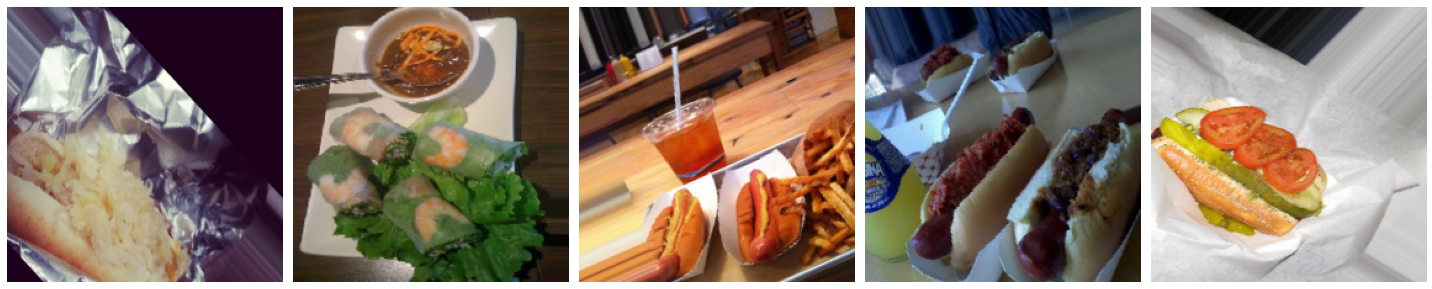

In [ ]:
plotImages(sample_training_images[:5])

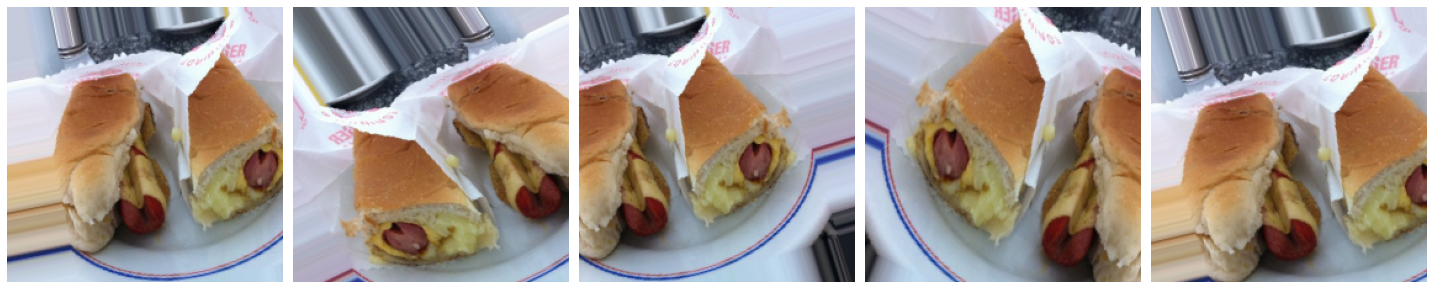

In [ ]:
# visualize augmented images

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Create the base model from the pre-trained convnets

In [ ]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)

classifier = tf.keras.Sequential([
  hub.KerasLayer(classifier_url, input_shape=IMG_SHAPE+(3,))
])

In [ ]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [ ]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMG_SHAPE+(3,))

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(40, 1280)


In [ ]:
feature_extractor_layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  Dense(1, activation='sigmoid')                             
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model = hub.KerasLayer(classifier_url, dtype=tf.string, input_shape=[], 
                       output_shape=[WIDTH], name='inputs'),name=INPUT_TENSOR_NAME),
        tf.keras.layers.Dense(256, 'relu', name ='layer_1'),
        tf.keras.layers.Dense(128, 'relu', name = 'layer_2'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')
    ])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    run_eagerly=True,
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_data_gen, 
                    epochs=15,
                    validation_data = val_data_gen)

Epoch 1/15
20/20 [==============================] - 14s 678ms/step - loss: 0.6503 - accuracy: 0.7053 - val_loss: 0.5988 - val_accuracy: 0.8227
Epoch 2/15
20/20 [==============================] - 12s 615ms/step - loss: 0.6011 - accuracy: 0.8476 - val_loss: 0.5735 - val_accuracy: 0.9163
Epoch 3/15
20/20 [==============================] - 12s 620ms/step - loss: 0.5835 - accuracy: 0.8678 - val_loss: 0.5624 - val_accuracy: 0.9113
Epoch 4/15
20/20 [==============================] - 13s 634ms/step - loss: 0.5746 - accuracy: 0.8929 - val_loss: 0.5583 - val_accuracy: 0.9261
Epoch 5/15
20/20 [==============================] - 12s 621ms/step - loss: 0.5707 - accuracy: 0.8854 - val_loss: 0.5556 - val_accuracy: 0.9310
Epoch 6/15
20/20 [==============================] - 12s 614ms/step - loss: 0.5623 - accuracy: 0.9043 - val_loss: 0.5534 - val_accuracy: 0.9360
Epoch 7/15
20/20 [==============================] - 12s 613ms/step - loss: 0.5630 - accuracy: 0.8866 - val_loss: 0.5515 - val_accuracy: 0.9310

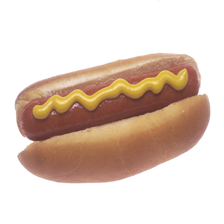

In [ ]:
import PIL.Image as Image

temp_img = tf.keras.utils.get_file('hd.png', 'https://upload.wikimedia.org/wikipedia/commons/f/f0/Hotdog.PNG')
temp_img = Image.open(temp_img).resize(IMG_SHAPE)

temp_img

In [ ]:
temp_img = np.array(temp_img)/255
temp_img.shape

(224, 224, 3)

In [ ]:
result = model.predict(temp_img)

result

ValueError: ignored